# Twitter Sentiment Analysis

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import logging
import time
import pickle
import itertools
import nltk
import gensim

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

%matplotlib inline

In [2]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
COLUMNS=["target", "ids", "date", "flag", "user", "text"]
ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.95

TEXT_CLEAR_REGEX = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

KERAS_MODEL = "twitter_sentiment_model.h5"
WORD2VEC_MODEL = "twitter_sentiment_model.w2v"
TOKENIZER_MODEL = "twitter_sentiment_tokenizer.pkl"
ENCODER_MODEL = "twitter_sentiment_encoder.pkl"

### Reading dataset

In [5]:
df = pd.read_csv('/content/drive/MyDrive/training.1600000.processed.noemoticon.csv', 
                 encoding=ENCODING, names=COLUMNS)

In [6]:
print("Size:", len(df))

Size: 1600000


In [7]:
df.sample(3)

,target,ids,date,flag,user,text
1373788,4,2051363038,Fri Jun 05 21:48:14 PDT 2009,NO_QUERY,Bobbbbbi,Just watched up with kk and fam bam. Going to ...
1069262,4,1965895566,Fri May 29 16:44:34 PDT 2009,NO_QUERY,luniluna,Huh. The internet signal seems to be stabling ...
1586126,4,2190771441,Tue Jun 16 03:40:53 PDT 2009,NO_QUERY,Jillianevelyn,I get to do some patterns today


#### Target label to Strings
- 0 **>>>** Negative
- 2 **>>>** Neutral
- 4 **>>>** Positive

In [8]:
decoder = {0: "NEGATIVE", 2: "NEUTRAL", 4:"POSITIVE"}

def decode_sentiment(label):
    return decoder[int(label)]

In [9]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 493 ms, sys: 2.69 ms, total: 495 ms
Wall time: 498 ms


<BarContainer object of 2 artists>

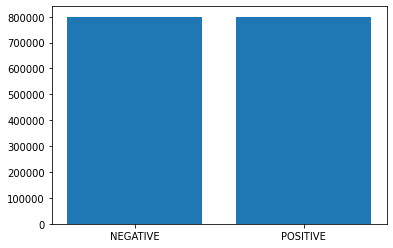

In [10]:
targets = Counter(df.target)

plt.bar(targets.keys(), targets.values())

### Preprocessing

In [11]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [12]:
def preprocessing(text, stem=False):
    text = re.sub(TEXT_CLEAR_REGEX, ' ', str(text).lower()).strip()
    tokens = []
    
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
        
    return " ".join(tokens)

In [13]:
%%time
df.text = df.text.apply(lambda x: preprocessing(x))

CPU times: user 50.4 s, sys: 201 ms, total: 50.6 s
Wall time: 50.7 s


In [14]:
df_train, df_test = train_test_split(df, train_size=TRAIN_SIZE, random_state=25)

In [15]:
len(df_train)

1520000

In [16]:
len(df_test)

80000

### Word2Vec

In [17]:
%%time
documents = [_text.split() for _text in df_train.text]

CPU times: user 2.91 s, sys: 393 ms, total: 3.3 s
Wall time: 3.31 s


In [19]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [20]:
w2v_model.build_vocab(documents)

In [22]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)

In [23]:
vocab_size

33588

In [24]:
%%time
w2v_model.train(documents, 
                total_examples=len(documents), 
                epochs=W2V_EPOCH)

CPU times: user 22min 14s, sys: 4.82 s, total: 22min 19s
Wall time: 11min 24s


(313543956, 350617120)

In [25]:
w2v_model.wv.similar_by_word("love")

[('luv', 0.5991935133934021),
 ('loves', 0.590000331401825),
 ('adore', 0.5755394697189331),
 ('loved', 0.5353175401687622),
 ('looove', 0.5230357646942139),
 ('amazing', 0.5069674253463745),
 ('loove', 0.4904833436012268),
 ('lovee', 0.47313177585601807),
 ('loveeeee', 0.4521527886390686),
 ('awesome', 0.4501841962337494)]

### Tokenize Text

In [26]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1

In [27]:
vocab_size

324507

In [28]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), 
                        maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), 
                       maxlen=SEQUENCE_LENGTH)

CPU times: user 22.9 s, sys: 702 ms, total: 23.6 s
Wall time: 23.4 s


### Label encoder

In [29]:
labels = df_train.target.unique().tolist()


In [30]:
labels

['POSITIVE', 'NEGATIVE']

In [31]:
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [32]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

In [33]:
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [34]:
print("x_train", x_train.shape,
"y_train", y_train.shape,
"\n",
"x_test", x_test.shape,
"y_test", y_test.shape)

x_train (1520000, 300) y_train (1520000, 1) 
 x_test (80000, 300) y_test (80000, 1)


### Embedding Layer

In [35]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

In [36]:
embedding_layer = Embedding(vocab_size, 
                            W2V_SIZE, 
                            weights=[embedding_matrix], 
                            input_length=SEQUENCE_LENGTH, 
                            trainable=False)

In [37]:
model = Sequential([
    embedding_layer,
    Dropout(0.5),
    LSTM(125, dropout=0.25, recurrent_dropout=0.25),
    Dense(1, activation='sigmoid')
])

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          97352100  
_________________________________________________________________
dropout (Dropout)            (None, 300, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 125)               213000    
_________________________________________________________________
dense (Dense)                (None, 1)                 126       
Total params: 97,565,226
Trainable params: 213,126
Non-trainable params: 97,352,100
_________________________________________________________________


In [39]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['acc']
)

In [40]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

#### Train

In [41]:
%%time
hist = model.fit(x_train, y_train,
                 batch_size=BATCH_SIZE,
                 epochs=EPOCHS,
                 validation_split=0.15,
                 verbose=1,
                 callbacks=callbacks
                )

Epoch 1/8
1262/1262 [==============================] - 1329s 1s/step - loss: 0.5240 - acc: 0.7347 - val_loss: 0.4612 - val_acc: 0.7817
Epoch 2/8
1262/1262 [==============================] - 1352s 1s/step - loss: 0.4819 - acc: 0.7654 - val_loss: 0.4564 - val_acc: 0.7852
Epoch 3/8
1262/1262 [==============================] - 1328s 1s/step - loss: 0.4753 - acc: 0.7702 - val_loss: 0.4536 - val_acc: 0.7875
Epoch 4/8
1262/1262 [==============================] - 1315s 1s/step - loss: 0.4714 - acc: 0.7723 - val_loss: 0.4512 - val_acc: 0.7881
Epoch 5/8
1262/1262 [==============================] - 1328s 1s/step - loss: 0.4689 - acc: 0.7739 - val_loss: 0.4483 - val_acc: 0.7892
Epoch 6/8
1262/1262 [==============================] - 1318s 1s/step - loss: 0.4676 - acc: 0.7743 - val_loss: 0.4479 - val_acc: 0.7900
Epoch 7/8
1262/1262 [==============================] - 1326s 1s/step - loss: 0.4658 - acc: 0.7758 - val_loss: 0.4462 - val_acc: 0.7911
Epoch 8/8
1262/1262 [==============================] - 

In [42]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

79/79 [==============================] - 14s 172ms/step - loss: 0.4446 - acc: 0.7928

ACCURACY: 0.7928375005722046
LOSS: 0.44463324546813965
CPU times: user 12 s, sys: 1.05 s, total: 13 s
Wall time: 13.7 s


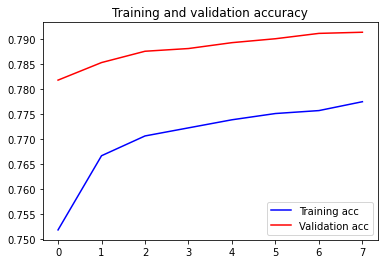

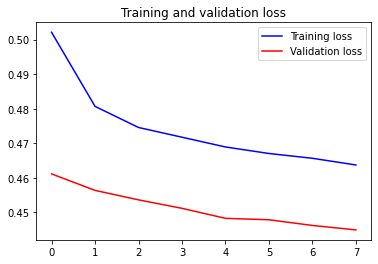

In [44]:
acc = hist.history['acc']
val_acc = hist.history['val_acc']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [45]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [46]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [47]:
predict("I love the music")

{'elapsed_time': 0.3110849857330322,
 'label': 'POSITIVE',
 'score': 0.9786145687103271}

In [48]:
predict("I hate the rain")

{'elapsed_time': 0.09333205223083496,
 'label': 'NEGATIVE',
 'score': 0.009862751699984074}

In [49]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

10/10 [==============================] - 14s 1s/step
CPU times: user 8.78 s, sys: 5.13 s, total: 13.9 s
Wall time: 13.7 s


In [50]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

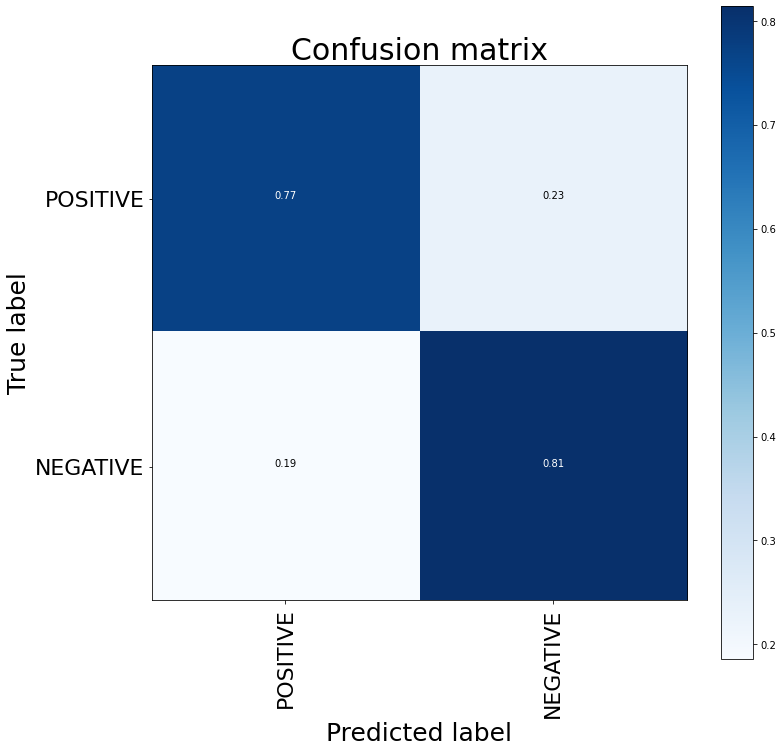

CPU times: user 512 ms, sys: 22.5 ms, total: 534 ms
Wall time: 517 ms


In [53]:
%%time
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

In [54]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.81      0.77      0.79     40036
    POSITIVE       0.78      0.81      0.80     39964

    accuracy                           0.79     80000
   macro avg       0.79      0.79      0.79     80000
weighted avg       0.79      0.79      0.79     80000



In [55]:
accuracy_score(y_test_1d, y_pred_1d)

0.7928375

In [ ]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)